## Initialise PySpark

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install pyspark
!pip install gcsfs

In [3]:
# Kill existing Spark session (if any)
try:
    spark.stop()
except NameError:
    pass  # Ignore if 'spark' is not defined yet


# Create a new Spark session with updated configuration
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GCS with PySpark in Colab") \
    .config("spark.jars.packages", "com.google.cloud.bigdataoss:gcs-connector:hadoop3-2.2.10") \
    .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .getOrCreate()

In [4]:
import pandas as pd
import networkx as nx
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from datetime import datetime, timedelta

## Create Spark Dataframe <br>

Create Spark Dataframe based on the dataset. <br>
- The full dataset takes around 51-60 mins to run
- A partitioned dataset (1 specific date and hour) takes 20s to run
- A partitioned dataset (2023-04-12 to 2023-04-29) takes 7 mins to run

Note that you need to create a unique local subdirectory for each day, else the files will be overwritten each day as they are downloaded.

In [5]:
import os

# Define project details and starting date
project_id = "project-clickstream-team-81"
bucket_name = "raw_partitioned-2"
dataset_name = "partitioned_output1"
start_date = "2023-04-01"  # Start date
num_days = 30  # Number of days to include

# Convert start_date to a datetime object
start_date = datetime.strptime(start_date, "%Y-%m-%d")

# Define the local directory to store all downloaded files
local_path = "/tmp/multi_day_dataset/"
os.makedirs(local_path, exist_ok=True)

# Loop through the range of dates and download files
for i in range(num_days):
    # Compute the current date
    current_date = start_date + timedelta(days=i)
    current_date_str = current_date.strftime("%Y-%m-%d")

    # Construct the GCS path for the current day
    source_path = f"gs://{project_id}/{bucket_name}/{dataset_name}/day={current_date_str}/**/*.parquet"

    # Define a unique local subdirectory for each day
    day_local_path = os.path.join(local_path, f"day={current_date_str}")
    os.makedirs(day_local_path, exist_ok=True)

    # Print the path being downloaded (for debugging purposes)
    print(f"Downloading files from: {source_path} to {day_local_path}")

    # Use gsutil to download the files
    !gsutil -m cp -r {source_path} {day_local_path}

# Load all downloaded files into a Spark DataFrame
print("Loading files into Spark DataFrame...")
df = spark.read.parquet(local_path)

CommandException: No URLs matched: gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-04-01/**/*.parquet
CommandException: 1 file/object could not be transferred.
CommandException: No URLs matched: gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-04-02/**/*.parquet
CommandException: 1 file/object could not be transferred.
CommandException: No URLs matched: gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-04-03/**/*.parquet
CommandException: 1 file/object could not be transferred.
CommandException: No URLs matched: gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-04-04/**/*.parquet
CommandException: 1 file/object could not be transferred.
CommandException: No URLs matched: gs://project-clickstream-team-81/raw_partitioned-2/partitioned_output1/day=2023-04-05/**/*.parquet
CommandException: 1 file/object could not be transferred.
CommandException: No URLs matched: gs://

In [6]:
# Display the schema and first few rows of the DataFrame
df.printSchema()
df.show()

root
 |-- token: integer (nullable = true)
 |-- fingerprint: string (nullable = true)
 |-- userToken: string (nullable = true)
 |-- siteId: integer (nullable = true)
 |-- userId: string (nullable = true)
 |-- url: string (nullable = true)
 |-- type: string (nullable = true)
 |-- group: string (nullable = true)
 |-- category: string (nullable = true)
 |-- action: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- visitKey: string (nullable = true)
 |-- groupSource: string (nullable = true)
 |-- day: date (nullable = true)

+-------+----------------+--------------------+------+------+--------------------+-------+-------+-----------+-----------+------+-------------------+--------------------+-----------+----------+
|  token|     fingerprint|           userToken|siteId|userId|                 url|   type|  group|   category|     action|  name|               time|            visitKey|groupSource|       day|
+-------+----------------+----

In [7]:
print(f"Row Count: {df.count()}")

Row Count: 1921


In [8]:
# Compute min and max time
time_stats_df = df.agg(
    min("time").alias("min_time"),
    max("time").alias("max_time")
).first()

# Extract the values
min_time_df = time_stats_df["min_time"]
max_time_df = time_stats_df["max_time"]

# Print the results
print(f"Min Time of df: {min_time_df}")
print(f"Max Time of df: {max_time_df}")

Min Time of df: 2023-04-12 23:00:11
Max Time of df: 2023-04-29 23:58:34


In [9]:
# Convert 'time' column to datetime
df = df.withColumn('time', to_timestamp(df['time']))

In [10]:
# Filter unnecessary columns
def sort_and_filter_clickstream_df(df):
    # Sort by 'token' and 'time' columns
    df_sorted = df.orderBy(["token", "time"])

    # Select the necessary columns
    columns_to_keep = ["token", "userToken", "userId", "url", "type", "category", "time", "visitKey", "groupSource"]
    df_filtered = df_sorted.select(*columns_to_keep)

    return df_filtered

## Create URL table
Create URL table (url_table) for storing page (node) information for each page_id. Also create merge_url function for future

In [11]:
def create_url_table(df):
    # Select the relevant columns and drop duplicate URLs
    url_table = df.select("url", "category", "type").dropDuplicates(["url"])

    # Add a unique page_id for each unique URL
    window_spec_url = Window.orderBy("url")  # Ordering by "url" for consistent page_id assignment
    url_table = url_table.withColumn("page_id", F.row_number().over(window_spec_url))

    # Rename columns as specified
    url_table = url_table.withColumnRenamed("category", "page_category") \
                         .withColumnRenamed("type", "page_type")

    # Reorder columns to match the required output
    url_table = url_table.select("page_id", "url", "page_category", "page_type")

    return url_table

In [12]:
def replace_url_with_id(df, url_table):
    # Join 'df' with 'url_table' on 'url' to get the corresponding 'page_id'
    df_merged = df.join(url_table.select("page_id", "url"), on="url", how="left")

    # Drop the original 'url' column and rename 'page_id'
    df_merged = df_merged.drop("url").withColumnRenamed("page_id", "page_id")

    return df_merged

In [13]:
def merge_url(df, url_table):
    df_merged = df.join(url_table, on="page_id", how="left")
    return df_merged

## Creating the DAG

Create a table of edges. <br>
The output, edge_data, should include an additional "cluster" column from the user_clusters dataframe.

In [22]:
def create_edges_table(df, user_clusters):
    # Define a window partitioned by 'token' and ordered by 'time'
    window_spec = Window.partitionBy("token").orderBy("time")

    # Add columns for next_page_id, source_time, and destination_time using window functions
    df_with_shifted = df.withColumn("next_page_id", lead("page_id").over(window_spec)) \
                        .withColumn("source_time", col("time")) \
                        .withColumn("destination_time", lead("time").over(window_spec))

    # Filter out rows where next_page_id or destination_time is null (last page in each token sequence)
    df_edges = df_with_shifted.filter(col("next_page_id").isNotNull() & col("destination_time").isNotNull())

    # Rename 'page_id' to 'source_page_id' and 'next_page_id' to 'destination_page_id'
    df_edges = df_edges.withColumnRenamed("page_id", "source_page_id") \
                       .withColumnRenamed("next_page_id", "destination_page_id")

    # Add depth column using row_number
    df_edges = df_edges.withColumn("depth", row_number().over(window_spec))

    # Calculate time difference in seconds
    df_edges = df_edges.withColumn("time_diff", (col("destination_time").cast("long") - col("source_time").cast("long")))

    # Ensure IDs are integers
    df_edges = df_edges.withColumn("source_page_id", col("source_page_id").cast("int")) \
                       .withColumn("destination_page_id", col("destination_page_id").cast("int"))

    # Rename userId in df to match the join column name
    df_edges = df_edges.withColumnRenamed("userId", "user_id")

    # Rename userId in user_clusters to match the join column name
    user_clusters = user_clusters.withColumnRenamed("userId", "user_id")

    # Perform an explicit join using 'user_id'
    df_edges_with_clusters = df_edges.join(user_clusters, df_edges["user_id"] == user_clusters["user_id"], how="left")

    # Rename 'prediction' to 'cluster'
    df_edges_with_clusters = df_edges_with_clusters.withColumnRenamed("prediction", "cluster")

    # Select the relevant columns for the edge data
    edge_data = df_edges_with_clusters.select("token", "source_page_id", "destination_page_id",
                                              "source_time", "destination_time", "time_diff",
                                              "depth", "cluster")

    return edge_data

Create a function that exports edges from a specified timeframe and aggregates them. <br>
The output, edges_table_export, should contain extra columns, summing up the number of occurrences of each cluster for each edge.

In [15]:
def create_edges_table_export(edges_df, time, duration):
    """
    Generate an aggregated export edges table from the whole edges table based on unique edges within a specified time range.
    Parameters:
        edges_df (DataFrame): The PySpark DataFrame containing edge data.
        time (str): The start date for filtering in 'YYYY-MM-DD' format.
        duration (int): The number of days from the start time to determine the end time.
    Returns:
        DataFrame: Aggregated edges table with the required columns.
    """
    start_time = datetime.strptime(time, "%Y-%m-%d")

    # Determine the start and end of the time range based on duration
    if duration >= 0:
        end_time = start_time + timedelta(days=duration)
    else:
        start_time = start_time + timedelta(days=duration)
        end_time = datetime.strptime(time, "%Y-%m-%d")


    # Filter edges within the specified time range
    edges_filtered = edges_df.filter(
        (col("source_time") >= start_time) & (col("source_time") <= end_time) |
        (col("destination_time") >= start_time) & (col("destination_time") <= end_time)
    )

    # Filter out rows where source_page_id is the same as destination_page_id
    edges_filtered = edges_filtered.filter(col("source_page_id") != col("destination_page_id"))

    ######### DEBUG
    print("Filtered edges count:", edges_filtered.count())
    edges_filtered.show(10)

    # Aggregate data by unique edges (source_page_id, destination_page_id)
    edges_table_export = edges_filtered.groupBy("source_page_id", "destination_page_id").agg( # Page ID of starting and destination page
        count("depth").alias("transition_count"),  # Total count of transitions from source to destination
        mean("time_diff").alias("avg_time_between_pages"),  # Average time taken to navigate from source to destination
        max("destination_time").alias("last_visit_timestamp"),  # Timestamp of the most recent transition
        mean("depth").alias("avg_path_depth"),  # Average depth of this transition across sessions
        countDistinct("token").alias("unique_token_count"),  # Count of unique tokens
        sum(when(col("cluster") == 0, 1).otherwise(0)).alias("k_1"),  # Count of cluster 0
        sum(when(col("cluster") == 1, 1).otherwise(0)).alias("k_2"),  # Count of cluster 1
        sum(when(col("cluster") == 2, 1).otherwise(0)).alias("k_3"),  # Count of cluster 2
        sum(when(col("cluster") == 3, 1).otherwise(0)).alias("k_4")   # Count of cluster 3
    )

    # Ensure correct data types for each columns
    edges_table_export = edges_table_export.select(
        col("source_page_id").cast("int"),
        col("destination_page_id").cast("int"),
        col("transition_count").cast("int"),
        col("avg_time_between_pages").cast("double"),
        col("last_visit_timestamp"),
        col("avg_path_depth").cast("double"),
        col("unique_token_count").cast("int"),
        col("k_1").cast("int"),
        col("k_2").cast("int"),
        col("k_3").cast("int"),
        col("k_4").cast("int")
    )

    return edges_table_export

Create a function that exports nodes, but collects edge data for 2 time periods and aggregates them.

In [16]:
def create_nodes_table_export(edges_df, time, n_days):
    """
    Generate the nodes table export based on edge data.
    Parameters:
        edges_df (DataFrame): The PySpark DataFrame containing edge data.
        time (str): The reference date for filtering in 'YYYY-MM-DD' format.
        n_days (int): Number of days for the last period and the previous period comparison.
    Returns:
        DataFrame: Nodes table with the required columns.
    """
    time = datetime.strptime(time, "%Y-%m-%d")
    last_period_start = time - timedelta(days=n_days)
    prev_period_start = time - timedelta(days=2 * n_days)

    ######### DEBUG
    print(f"Last period start: {last_period_start}, Previous period start: {prev_period_start}")

    # Get edges within the last n days and previous n days
    last_period_edges = create_edges_table_export(edges_df, last_period_start.strftime("%Y-%m-%d"), n_days)
    if last_period_edges.count() == 0:
        print("No data for last period edges.")
        return None

    prev_period_edges = create_edges_table_export(edges_df, prev_period_start.strftime("%Y-%m-%d"), n_days)
    if prev_period_edges.count() == 0:
        print("No data for previous period edges.")
        return None

    ######### DEBUG
    print("Last period edges count:", last_period_edges.count())
    last_period_edges.show(10)
    print("Previous period edges count:", prev_period_edges.count())
    prev_period_edges.show(10)

    # Aggregate visits and unique visitors in the last n days
    last_period_visits = last_period_edges.groupBy("destination_page_id").agg(
        sum("transition_count").alias("visits_last_n_days"),
        sum("unique_token_count").alias("unique_visitors_last_n_days")
    )

    # Aggregate visits in the previous n days
    prev_period_visits = prev_period_edges.groupBy("destination_page_id").agg(
        sum("transition_count").alias("prev_visits")
    )

    # Merge data for trend calculation
    nodes_table_export = last_period_visits.join(
        prev_period_visits,
        on="destination_page_id",
        how="left"
    ).fillna({"prev_visits": 0})

    # Calculate trend percentage
    nodes_table_export = nodes_table_export.withColumn(
        "trend_percentage",
        when(col("prev_visits") == 0, lit(99999)).otherwise(
            ((col("visits_last_n_days") - col("prev_visits")) / col("prev_visits")) * 100
        )
    )

    # Rename destination_page_id to page_id
    nodes_table_export = nodes_table_export.withColumnRenamed("destination_page_id", "page_id")

    # Ensure correct data types for each column
    nodes_table_export = nodes_table_export.select(
        col("page_id").cast("int"),
        col("visits_last_n_days").cast("int").alias("visits_last_" + str(n_days) + "_days"),
        col("unique_visitors_last_n_days").cast("int").alias("unique_visitors_last_" + str(n_days) + "_days"),
        col("trend_percentage").cast("double")
    )

    return nodes_table_export

Combine edges export and nodes export function

In [17]:
def export_edges_and_nodes(edges_df, url_table, time, days=7):

    # Process edges
    edges_export = create_edges_table_export(edges_df, time, days)

    # Process nodes
    nodes_export = create_nodes_table_export(edges_df, time, days)
    if nodes_export is None:
        print("Warning: Nodes export is None. Skipping node-related processing.")
        return edges_export, None, url_table, None

    # Drop unnecessary columns
    edges_export = edges_export.drop("unique_token_count")
    nodes_export = nodes_export.drop("prev_visits")

    # Merge nodes export with URL table
    nodes_export_with_url = nodes_export.join(url_table, on="page_id", how="left")

    return edges_export, nodes_export, url_table, nodes_export_with_url

## Execute functions

In [18]:
df_filtered = sort_and_filter_clickstream_df(df)
url_table = create_url_table(df_filtered)

# (optional) check times
# start_time = df_filtered['time'].min()
# end_time = df_filtered['time'].max()
# print("Start Time:", start_time)
# print("End Time:", end_time)

df_filtered = replace_url_with_id(df_filtered, url_table)

In [19]:
# Load user_clusters dataset into a PySpark Dataframe
# TODO: join Lu's code with this code so that the user_clusters data don't need to be downloaded and reuploaded again
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving user_clusters.csv to user_clusters.csv


In [20]:
user_clusters = spark.read.csv("/content/user_clusters.csv", header=True, inferSchema=True)

In [23]:
edge_data = create_edges_table(df_filtered, user_clusters)

In [24]:
######### DEBUG
# Compute min and max times
time_stats_edge = edge_data.select(
    col("source_time").cast("timestamp").alias("source_time"),
    col("destination_time").cast("timestamp").alias("destination_time")
).agg(
    min("source_time").alias("min_source_time"),
    max("source_time").alias("max_source_time"),
    min("destination_time").alias("min_destination_time"),
    max("destination_time").alias("max_destination_time")
).first()

min_source_time = time_stats_edge["min_source_time"]
max_source_time = time_stats_edge["max_source_time"]
min_destination_time = time_stats_edge["min_destination_time"]
max_destination_time = time_stats_edge["max_destination_time"]

print(f"Min Source Time: {min_source_time}")
print(f"Max Source Time: {max_source_time}")
print(f"Min Destination Time: {min_destination_time}")
print(f"Max Destination Time: {max_destination_time}")

Min Source Time: 2023-04-12 23:00:11
Max Source Time: 2023-04-29 23:58:33
Min Destination Time: 2023-04-12 23:00:11
Max Destination Time: 2023-04-29 23:58:34


In [25]:
######### DEBUG
# Count the number of rows in edges_df
row_count_df = df.count()
row_count_df_filtered = df_filtered.count()
row_count_edge_data = edge_data.count()

# Output the result
print(f"The DataFrame contains {row_count_df} rows.")
print(f"The Filtered DataFrame contains {row_count_df_filtered} rows.")
print(f"The Edges DataFrame contains {row_count_edge_data} rows.")

The DataFrame contains 1921 rows.
The Filtered DataFrame contains 1921 rows.
The Edges DataFrame contains 1828 rows.


In [26]:
time = "2023-04-20"
days = 7

edges_export, nodes_export, url_table, nodes_export_with_url = export_edges_and_nodes(edge_data, url_table, time, days)

Filtered edges count: 47
+-------+--------------+-------------------+-------------------+-------------------+---------+-----+-------+
|  token|source_page_id|destination_page_id|        source_time|   destination_time|time_diff|depth|cluster|
+-------+--------------+-------------------+-------------------+-------------------+---------+-----+-------+
|1403058|           206|                229|2023-04-20 22:09:50|2023-04-20 22:13:03|      193|    1|      0|
|1403058|           229|                193|2023-04-20 22:13:03|2023-04-20 22:13:49|       46|    2|      0|
|1403058|           193|                191|2023-04-20 22:16:33|2023-04-20 22:18:57|      144|    5|      0|
|1403060|           331|                332|2023-04-20 22:13:30|2023-04-20 22:14:08|       38|    1|   NULL|
|1403065|           192|                267|2023-04-20 22:23:10|2023-04-20 22:23:23|       13|    1|   NULL|
|1403069|           269|                270|2023-04-20 22:39:42|2023-04-20 22:40:17|       35|    1|   

In [27]:
# Print schema
edges_export.printSchema()
nodes_export.printSchema()
url_table.printSchema()
nodes_export_with_url.printSchema()

root
 |-- source_page_id: integer (nullable = true)
 |-- destination_page_id: integer (nullable = true)
 |-- transition_count: integer (nullable = false)
 |-- avg_time_between_pages: double (nullable = true)
 |-- last_visit_timestamp: timestamp (nullable = true)
 |-- avg_path_depth: double (nullable = true)
 |-- k_1: integer (nullable = true)
 |-- k_2: integer (nullable = true)
 |-- k_3: integer (nullable = true)
 |-- k_4: integer (nullable = true)

root
 |-- page_id: integer (nullable = true)
 |-- visits_last_7_days: integer (nullable = true)
 |-- unique_visitors_last_7_days: integer (nullable = true)
 |-- trend_percentage: double (nullable = true)

root
 |-- page_id: integer (nullable = false)
 |-- url: string (nullable = true)
 |-- page_category: string (nullable = true)
 |-- page_type: string (nullable = true)

root
 |-- page_id: integer (nullable = true)
 |-- visits_last_7_days: integer (nullable = true)
 |-- unique_visitors_last_7_days: integer (nullable = true)
 |-- trend_percen

In [28]:
# Check current working directory
!pwd

/content


In [29]:
# Save as CSV files
edge_data.write.csv('/content/edge_data.csv', header=True, mode="overwrite")
edges_export.write.csv('/content/edges_export.csv', header=True, mode="overwrite")
nodes_export.write.csv('/content/nodes_export.csv', header=True, mode="overwrite")
url_table.write.csv('/content/url_table.csv', header=True, mode="overwrite")
nodes_export_with_url.write.csv('/content/nodes_export_with_url.csv', header=True, mode="overwrite")

In [30]:
# Check contents in the current working directory
!ls

edge_data.csv	  nodes_export.csv	     sample_data    user_clusters.csv
edges_export.csv  nodes_export_with_url.csv  url_table.csv


In [31]:
from google.colab import files

files.download('/content/edge_data.csv')
files.download('/content/edges_export.csv')
files.download('/content/nodes_export.csv')
files.download('/content/url_table.csv')
files.download('/content/nodes_export_with_url.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualise the DAG using networkx and matplotlib

+--------------+-------------------+----------------+----------------------+--------------------+--------------+---+---+---+---+
|source_page_id|destination_page_id|transition_count|avg_time_between_pages|last_visit_timestamp|avg_path_depth|k_1|k_2|k_3|k_4|
+--------------+-------------------+----------------+----------------------+--------------------+--------------+---+---+---+---+
|            47|                102|               1|                  22.0| 2023-04-20 23:16:57|           9.0|  1|  0|  0|  0|
|           368|                102|               1|                   6.0| 2023-04-20 23:17:13|          15.0|  1|  0|  0|  0|
|           107|                413|               1|                 146.0| 2023-04-20 22:51:07|           5.0|  0|  0|  0|  1|
|           206|                229|               1|                 193.0| 2023-04-20 22:13:03|           1.0|  1|  0|  0|  0|
|            46|                 47|               1|                  36.0| 2023-04-20 23:16:34|

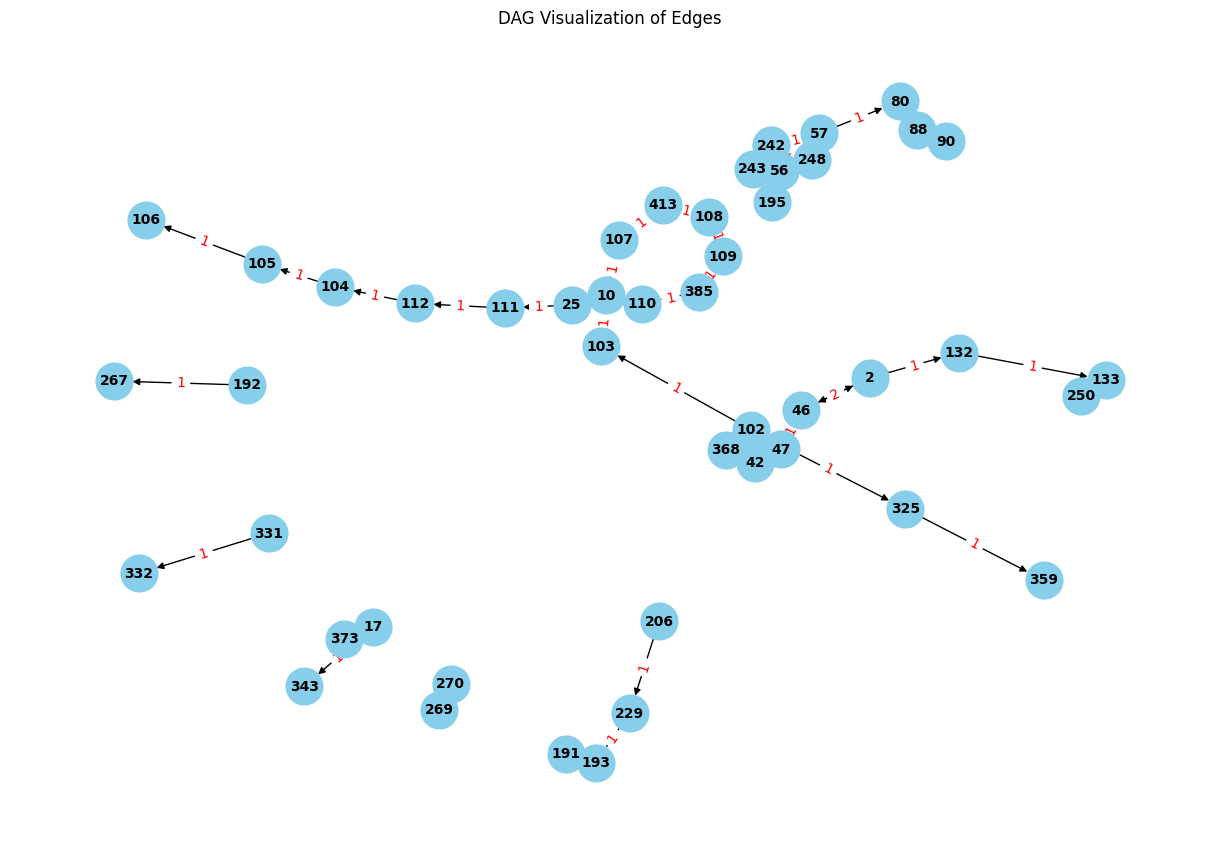

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

# Verify edges_export has data
edges_export.show(10)
print("Number of rows in edges_export:", edges_export.count())

# Convert edges_export to a list of tuples
edges = [
    (
        row["source_page_id"],
        row["destination_page_id"],
        {
            "transition_count": row["transition_count"],
            "avg_time_between_pages": row["avg_time_between_pages"],
            "avg_path_depth": row["avg_path_depth"]
        }
    )
    for row in edges_export.collect()
]
print("Edges:", edges)

# Initialize a directed graph
G = nx.DiGraph()

# Add edges to the graph
G.add_edges_from(edges)

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(
    G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_weight="bold"
  )
edge_labels = {(u, v): f"{d['transition_count']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
plt.title("DAG Visualization of Edges")
plt.show()

In [33]:
# Display some basic information about the DAG
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 47
Number of edges: 46
